# This notebook is for BGS specific results

In [1]:
import numpy as np
import fitsio
from matplotlib import pyplot as plt
import os
from scipy.special import erf

In [2]:
ff = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/ztile-sv3-bright-cumulative.fits')
wbgs = ff['COADD_FIBERSTATUS'] == 0
ff = ff[wbgs]
wz = ff['ZWARN'] == 0
wz &= ff['DELTACHI2']>40

In [3]:
wtp = (ff['PRIORITY'] == 102000) | (ff['PRIORITY'] == 102100)
print(len(ff[wtp]),len(ff[wtp&wz]),len(ff[wtp&wz])/len(ff[wtp]))

259128 254069 0.9804768299836374


In [18]:
np.unique(ff['PETAL_LOC'])
#ff.dtype.names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int16)

176442
173031


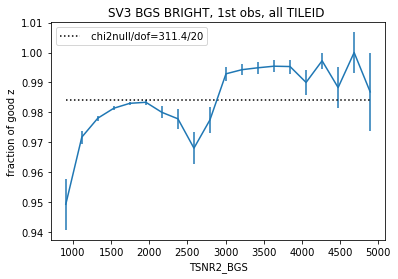

In [3]:
efac = 1#8.60
regl = ['N','S']
#for fr,reg in zip(frl,regl):
#wa = ff['LOCATION_ASSIGNED'] == 1
wa = ff['TSNR2_BGS'] != 1e20
wa &= ff['PRIORITY'] == 102100
wa &= ff['PETAL_LOC'] != 99
#wa &= ff['TILEID'] != 120
#wa &= ff['TSNR2_LRG'] > 70
wgh = wa & wz
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
rng = (800,5000)
nb = 20
#bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_BGS'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_BGS'],bins=a[1])
#plt.clf()
bs = a[1][1]-a[1][0]
fr = np.mean(a[0]/b[0])
dl = a[0]/b[0]#/fr
varl = dl*b[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
em = erf((vs-13.2)/39.7)*.9855

chi2null = np.sum((dl-fr)**2./el**2.)
chi2m = np.sum((dl-em)**2./el**2.)
plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el)#,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:',label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))
#plt.plot(vs*efac,em,'k--',label=' chi2mod/dof='+str(round(chi2m,1))+'/'+str(nb-3))             
plt.title('SV3 BGS BRIGHT, 1st obs, all TILEID ')
plt.xlabel('TSNR2_BGS')
plt.ylabel('fraction of good z')
plt.legend(loc='upper left')
plt.show()  

In [16]:
def tile2rosette(tile):
    if tile < 433:
        return (tile-1)//27
    else:
        if tile >= 433 and tile < 436:
            return 13
        if tile >= 436 and tile < 439:
            return 14
        if tile >= 439 and tile < 442:
            return 15
        if tile >= 442 and tile <=480:
            return (tile-442)//3
            
        if tile > 480:
            return tile//30    
    return 999999 #shouldn't be any more?


In [27]:
sel = ff['TSNR2_BGS'] > 0
sel &= ff['TSNR2_BGS'] < 500000
sel &= ff['PRIORITY'] == 102100
print(len(ff[sel]))
a,b = np.unique(ff[sel]['TILEID'],return_counts=True)
sl = []
tl = []
til = []
for tid,n in zip(a,b):
    if n > 1000:
        seln = ff['TILEID'] == tid
        print(tid,n,len(ff[seln&sel&wz])/len(ff[seln&sel]),np.std(ff[seln&sel]['TSNR2_BGS']),np.median(ff[seln&sel]['TSNR2_BGS']))
        sl.append(len(ff[seln&sel&wz])/len(ff[seln&sel]))
        tl.append(np.median(ff[seln&sel]['TSNR2_BGS']))
        ros = tile2rosette(tid)
        til.append(ros)
        #print(tid,n,len(ff[seln&wz])/len(ff[seln]))

176442
12 2688 0.9836309523809523 456.96774 1577.0554
13 2026 0.9891411648568608 203.53065 1748.9874
14 1365 0.9904761904761905 164.5741 1594.9971
39 2865 0.9916230366492147 206.75359 1496.9329
40 2225 0.9878651685393258 184.09943 1562.8606
41 1648 0.9854368932038835 189.94864 1666.9717
42 1150 0.9852173913043478 177.16237 1712.7043
66 2805 0.9957219251336898 1877.7748 2989.1357
67 2052 0.9839181286549707 170.14102 1499.0769
68 1543 0.9876863253402463 583.0484 1561.222
93 2633 0.9783516900873528 746.2147 1510.2891
94 1921 0.980739198334201 229.6569 1530.1476
95 1324 0.9894259818731118 598.9086 1645.2759
120 2934 0.9471710974778459 1749.5493 2250.3916
121 2363 0.9212865002115954 222.79018 1709.7102
122 1731 0.9324090121317158 183.79236 1639.0706
123 1210 0.9297520661157025 141.08743 1398.7073
147 2666 0.9898724681170292 165.23383 1402.6417
148 1990 0.9864321608040201 184.91476 1552.704
149 1519 0.9809084924292297 189.55913 1690.7444
174 2376 0.9844276094276094 174.78685 1435.852
175 164

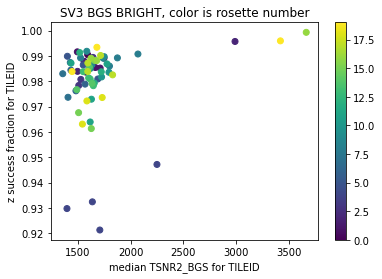

In [28]:
plt.scatter(tl,sl,c=til)
plt.title('SV3 BGS BRIGHT, color is rosette number')
plt.ylabel('z success fraction for TILEID')
plt.xlabel('median TSNR2_BGS for TILEID')
plt.colorbar()
plt.show()

In [20]:
rn = []
for tid in ff['TILEID']:
    rn.append(tile2rosette(tid))

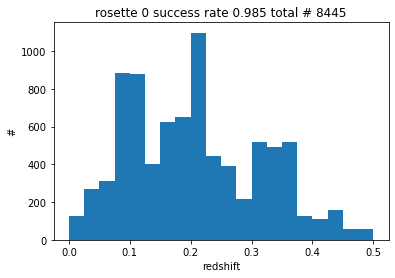

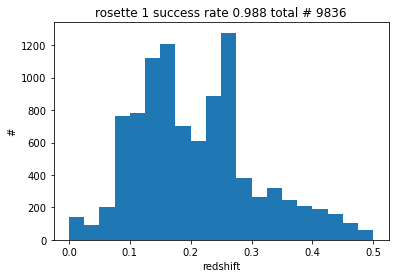

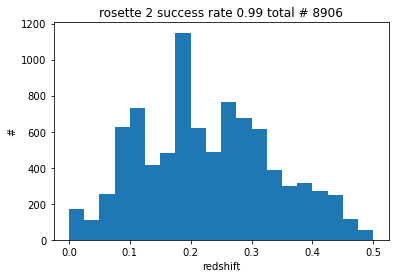

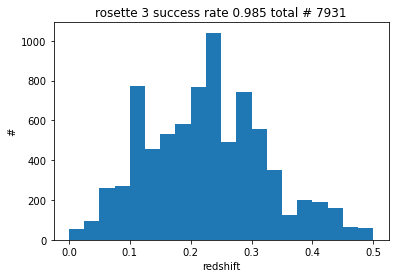

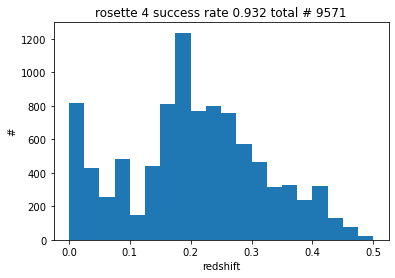

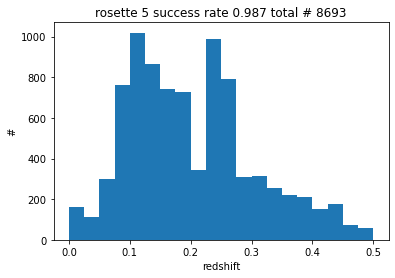

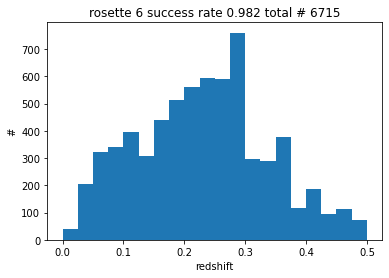

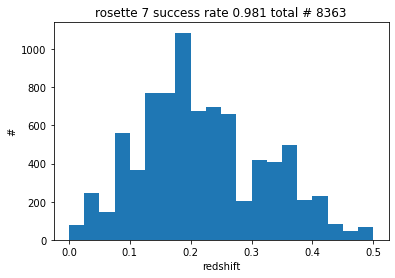

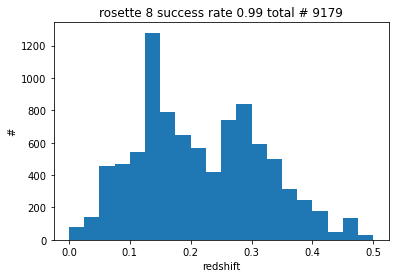

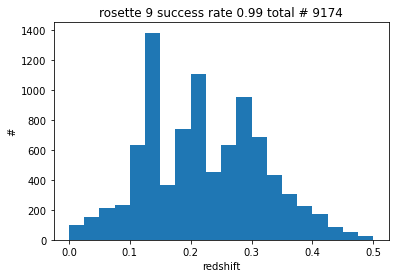

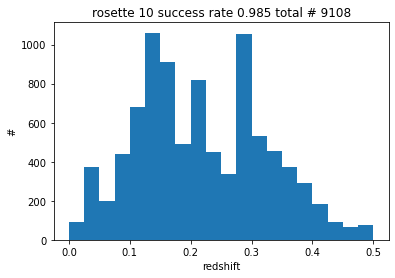

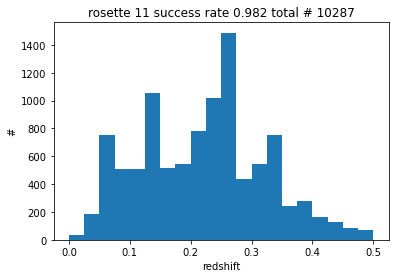

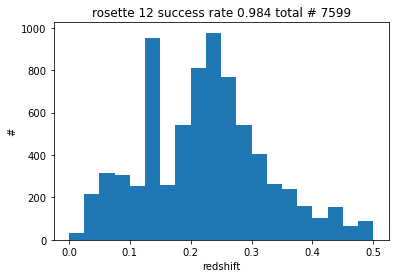

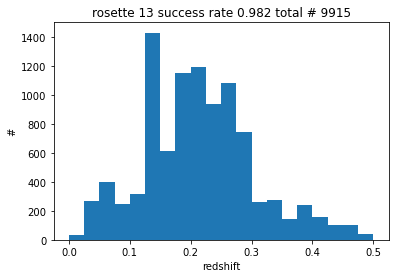

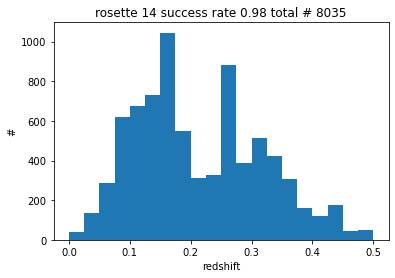

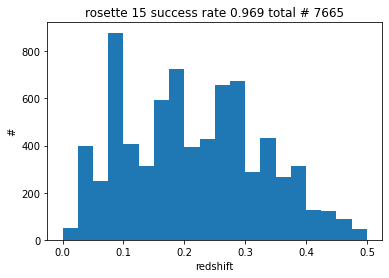

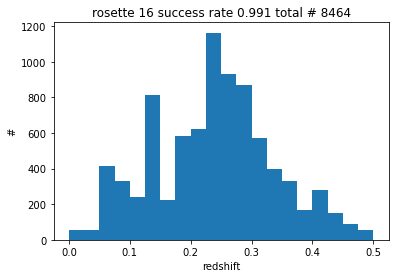

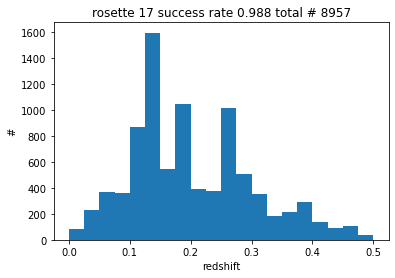

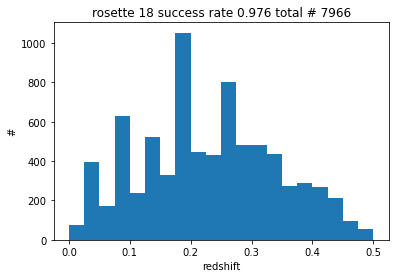

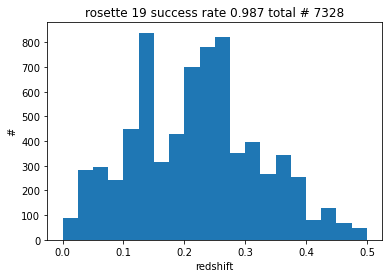

In [31]:
rn = np.array(rn)
rl = []
sl = []
tl = []
sel = ff['TSNR2_BGS'] > 800
sel &= ff['TSNR2_BGS'] < 5000
sel &= ff['PRIORITY'] == 102100

for r in np.unique(rn):
    seln = rn == r
    sr = len(ff[seln&sel&wz])/len(ff[seln&sel])
    sl.append(sr)
    rl.append(r)
    tl.append(np.median(ff[seln&sel]['TSNR2_BGS']))
    plt.hist(ff[seln&sel&wz]['Z'],bins=20,range=(0,0.5))
    plt.title('rosette '+str(r)+' success rate '+str(round(sr,3))+' total # '+str(len(ff[seln&sel&wz])))
    plt.xlabel('redshift')
    plt.ylabel('#')
    plt.show()
    

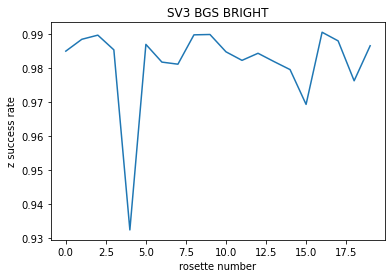

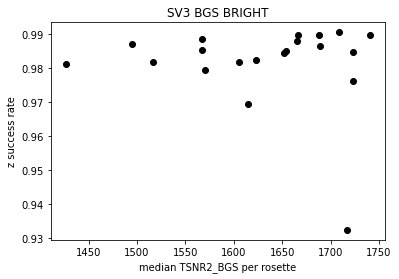

In [24]:
plt.plot(rl,sl)
plt.xlabel('rosette number')
plt.ylabel('z success rate')
plt.title('SV3 BGS BRIGHT')
plt.show()
plt.plot(tl,sl,'ko')
plt.xlabel('median TSNR2_BGS per rosette')
plt.ylabel('z success rate')
plt.title('SV3 BGS BRIGHT')
plt.show()


82686
81038


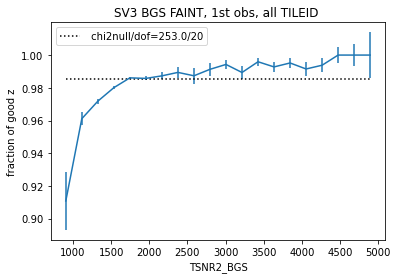

In [40]:
efac = 1#8.60
regl = ['N','S']
#for fr,reg in zip(frl,regl):
#wa = ff['LOCATION_ASSIGNED'] == 1
wa = ff['TSNR2_BGS'] != 1e20
wa &= ff['PRIORITY'] == 102000
#wa &= ff['TSNR2_LRG'] > 70
wgh = wa & wz
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
rng = (800,5000)
nb = 20
#bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_BGS'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_BGS'],bins=a[1])
#plt.clf()
bs = a[1][1]-a[1][0]
fr = np.mean(a[0]/b[0])
dl = a[0]/b[0]#/fr
varl = dl*b[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
em = erf((vs-13.2)/39.7)*.9855

chi2null = np.sum((dl-fr)**2./el**2.)
chi2m = np.sum((dl-em)**2./el**2.)
plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el)#,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:',label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))
#plt.plot(vs*efac,em,'k--',label=' chi2mod/dof='+str(round(chi2m,1))+'/'+str(nb-3))             
plt.title('SV3 BGS FAINT, 1st obs, all TILEID ')
plt.xlabel('TSNR2_BGS')
plt.ylabel('fraction of good z')
plt.legend(loc='upper left')
plt.show()  

(array([7.20000e+01, 9.09000e+02, 5.26970e+04, 1.01751e+05, 1.04650e+04,
        2.82000e+03, 3.53200e+03, 2.28500e+03, 9.60000e+02, 3.13000e+02]),
 array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500., 5000.], dtype=float32),
 <a list of 10 Patch objects>)

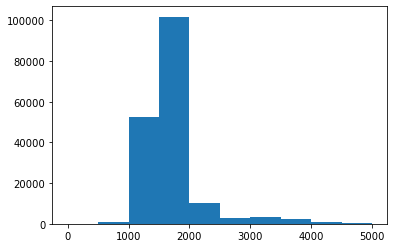

In [11]:
plt.hist(ffo['TSNR2_BGS'],range=(0,5000))

In [5]:
np.unique(ff['PRIORITY'],return_counts=True)

(array([    -1,      0,      2,     90,    400,   1005,   1025,   1450,
          1700,   1998,   9999,  81400,  81500,  82000,  82100,  82998,
         91400,  91500,  91600,  92000,  92100,  92998, 101400, 101500,
        101550, 101600, 102000, 102100, 102998], dtype=int32),
 array([ 93267, 158191, 288031,   3352,    171,    113,      6,    221,
          5656,    115,    334,      8,     44,    632,   1570,     47,
            37,    111,      1,   1308,   2758,     58,  93588, 133775,
           456,    346,  89558, 193315,    931]))

In [2]:
ff = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/test/BGS_ANY_full.dat.fits')

In [4]:
wz = ff['COADD_FIBERSTATUS'] == 0
ffz = ff[wz]
print(len(ff),len(ffz))

265201 249872


total number of unique reachable BGS targets is 265201
total number of unique observed BGS targets is 249872
total number of unique BGS targets with good redshifts is 248482
targeting completeness is 0.9421985588289636
redshift success rate is 0.9944371518217328


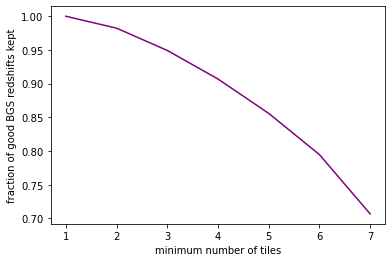

In [3]:
print('total number of unique reachable BGS targets is '+str(len(ff)))
wo = ff['LOCATION_ASSIGNED'] == 1
print('total number of unique observed BGS targets is '+str(len(ff[wo])))
wz = ff['ZWARN'] == 0
print('total number of unique BGS targets with good redshifts is '+str(len(ff[wz])))
print('targeting completeness is '+str(len(ff[wo])/len(ff)))
print('redshift success rate is '+str(len(ff[wz])/len(ff[wo])))
ngl = [len(ff[wz])]
ntm = [1]
for nt in range(1,7):
    wt = ff['NTILE'] > nt
    ntm.append(nt+1)
    ngl.append(len(ff[wz&wt]))
plt.plot(ntm,np.array(ngl)/len(ff[wz]),color='purple')
plt.xlabel('minimum number of tiles')
plt.ylabel('fraction of good BGS redshifts kept')
plt.show()

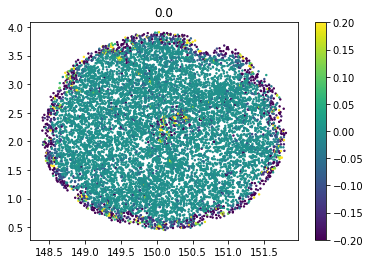

0.0 12245 12290.9296875 0.9962631234033735


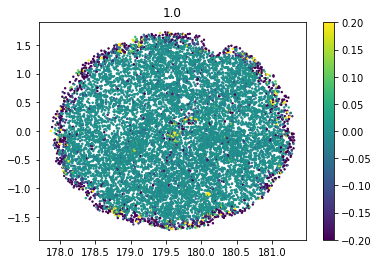

1.0 14080 14148.6796875 0.9951458589057836


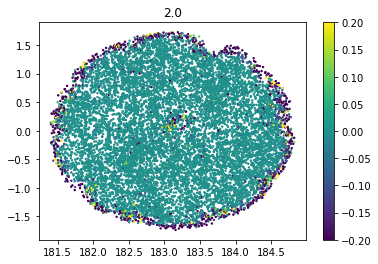

2.0 13363 13404.2578125 0.9969220367828553


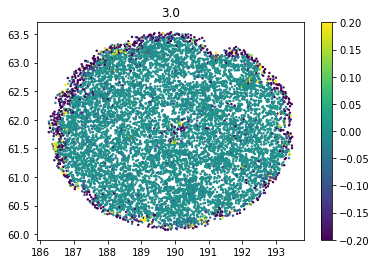

3.0 11621 11736.9765625 0.9901187020454187


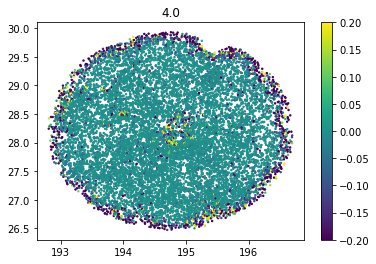

4.0 14409 14461.8125 0.996348141009296


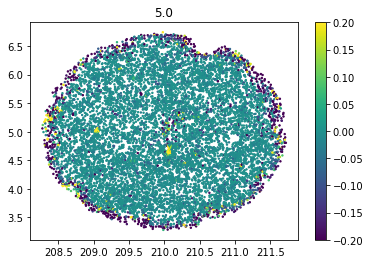

5.0 12232 12281.7109375 0.9959524419885004


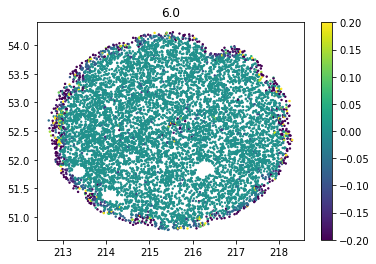

6.0 9973 10003.6796875 0.9969331597513728


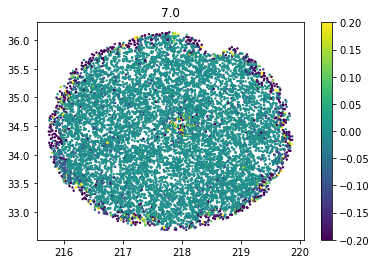

7.0 12150 12234.6484375 0.9930812529732733


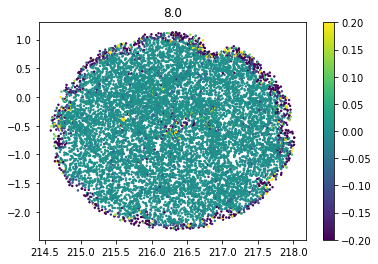

8.0 13423 13446.5078125 0.9982517533304709


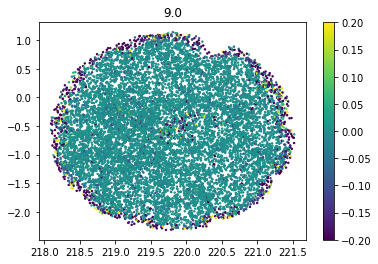

9.0 13573 13678.8046875 0.9922650633650258


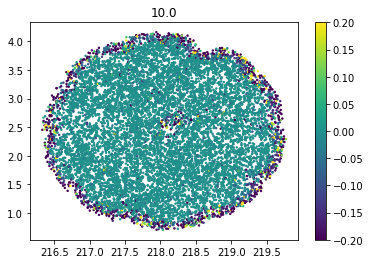

10.0 13152 13201.859375 0.9962233066128232


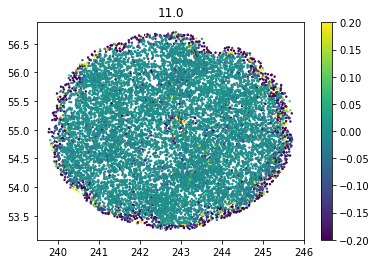

11.0 14365 14430.9453125 0.995430284636802


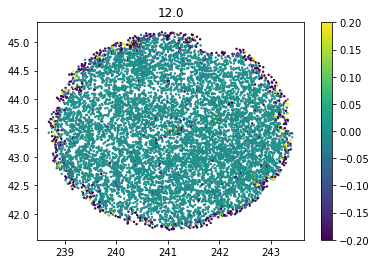

12.0 11097 11174.1171875 0.993098587905784


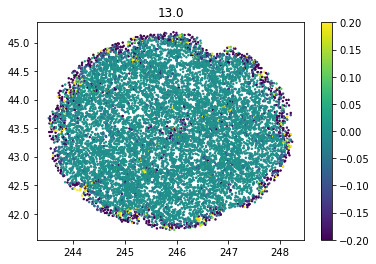

13.0 13870 13927.6328125 0.995861980763287


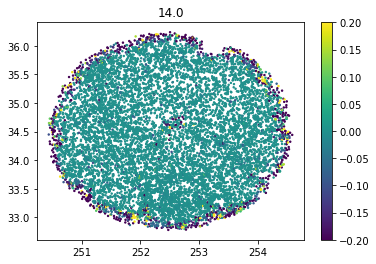

14.0 11249 11293.9140625 0.9960231623641328


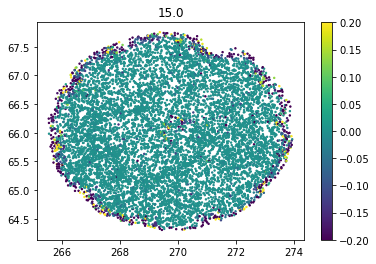

15.0 10742 10781.4453125 0.9963413706273437


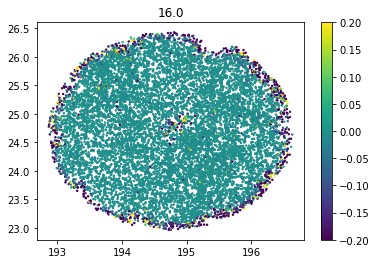

16.0 13057 13099.125 0.9967841363449849


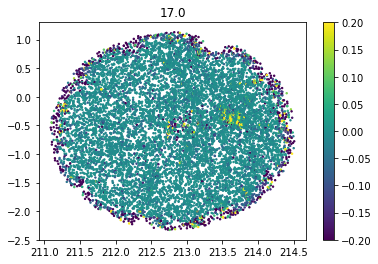

17.0 12876 12930.2421875 0.9958050138030332


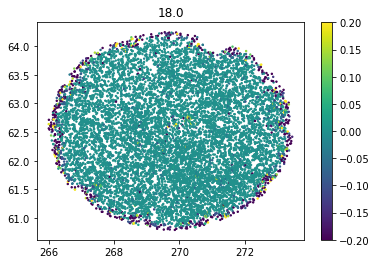

18.0 11709 11736.40625 0.9976648516235539


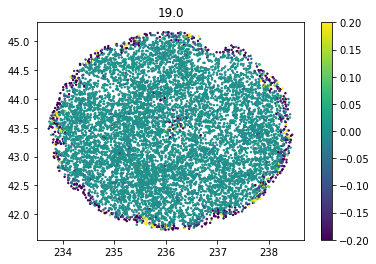

19.0 10686 10704.6484375 0.9982579121949795


In [5]:
for ros in np.unique(ffz['rosette_number']):
    sel = ffz['rosette_number'] == ros
    #sel &= ffz['PROB_OBS'] != 0
    plt.scatter(ffz[sel]['RA'],ffz[sel]['DEC'],c=ffz[sel]['COMP_TILE']-ffz[sel]['PROB_OBS'],s=2,vmin=-.2,vmax=.2)
    plt.title(str(ros))
    plt.colorbar()
    plt.show()
    selp = ff['rosette_number'] == ros
    
    print(ros,len(ffz[sel]),np.sum(ff[selp]['PROB_OBS']),len(ffz[sel])/np.sum(ff[selp]['PROB_OBS']))

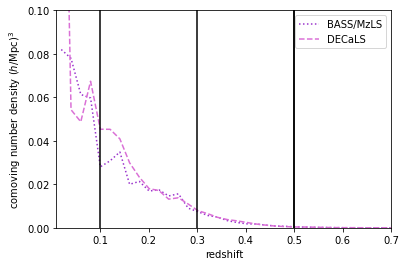

In [6]:
#plot n(z)
nz = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/BGS_ANY_N_nz.dat').transpose()
plt.plot(nz[0],nz[3],':',color='darkorchid',label='BASS/MzLS')
nz = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/BGS_ANY_S_nz.dat').transpose()
plt.plot(nz[0],nz[3],'--',color='orchid',label='DECaLS')
plt.legend()
plt.xlim(0.01,0.7)
plt.ylim(0,0.1)
xl = [0.1,0.1]
yl = [0,0.1]
plt.plot(xl,yl,'k-')
xl = [0.3,0.3]
yl = [0,0.1]
plt.plot(xl,yl,'k-')
xl = [0.5,0.5]
yl = [0,0.1]
plt.plot(xl,yl,'k-')
plt.plot(xl,yl,'k-')
plt.xlabel('redshift')
plt.ylabel(r'comoving number density ($h$/Mpc)$^3$')
plt.show()

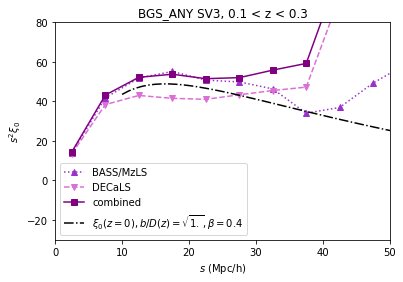

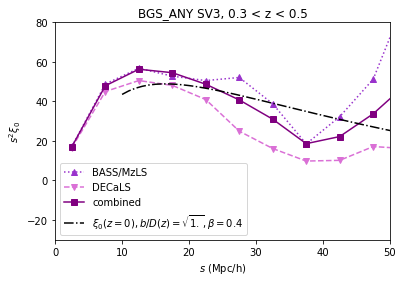

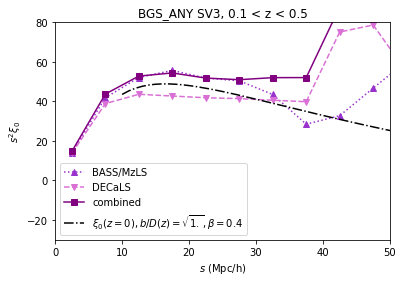

In [7]:
zl = [0.1,0.3,0.5]
for i in range(0,len(zl)):
    if i == len(zl)-1:
        zmin=zl[0]
        zmax=zl[-1]
    else:
        zmin = zl[i]
        zmax = zl[i+1]

    xils = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_1BGS_ANY_S'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    xil = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_1BGS_ANY'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    xiln = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_1BGS_ANY_N'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xil[0],xil[0]**2.*xiln[1],'^:',color='darkorchid',label='BASS/MzLS')
    plt.plot(xil[0],xil[0]**2.*xils[1],'v--',color='orchid',label='DECaLS')
    plt.plot(xil[0],xil[0]**2.*xil[1],'s-',color='purple',label='combined')
    xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    plt.plot(xilin[0],xilin[0]**2.*xilin[1]*1.,'k-.',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{1.},\beta=0.4$')

    plt.title('BGS_ANY SV3, '+str(zmin)+' < z < '+str(zmax))
    plt.xlim(0,50)
    plt.ylim(-30,80)
    plt.xlabel(r'$s$ (Mpc/h)')
    plt.ylabel(r'$s^2\xi_0$')
    plt.legend()
    plt.show()

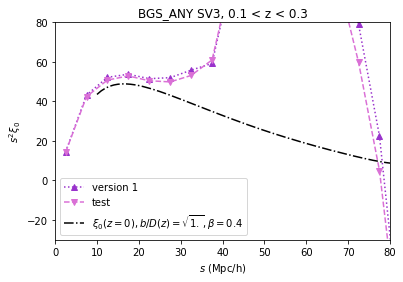

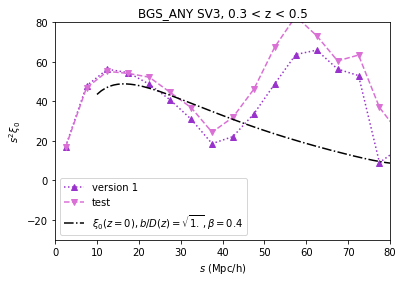

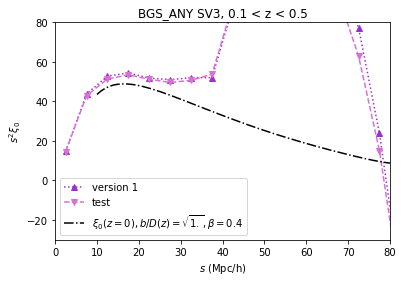

In [17]:
zl = [0.1,0.3,0.5]
for i in range(0,len(zl)):
    if i == len(zl)-1:
        zmin=zl[0]
        zmax=zl[-1]
    else:
        zmin = zl[i]
        zmax = zl[i+1]

    xil = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_1BGS_ANY'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    xiln = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testBGS_ANY'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xil[0],xil[0]**2.*xil[1],'^:',color='darkorchid',label='version 1')
    plt.plot(xil[0],xil[0]**2.*xiln[1],'v--',color='orchid',label='test')
    #plt.plot(xil[0],xil[0]**2.*xil[1],'s-',color='purple',label='combined')
    xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    plt.plot(xilin[0],xilin[0]**2.*xilin[1]*1.,'k-.',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{1.},\beta=0.4$')

    plt.title('BGS_ANY SV3, '+str(zmin)+' < z < '+str(zmax))
    plt.xlim(0,80)
    plt.ylim(-30,80)
    plt.xlabel(r'$s$ (Mpc/h)')
    plt.ylabel(r'$s^2\xi_0$')
    plt.legend()
    plt.show()

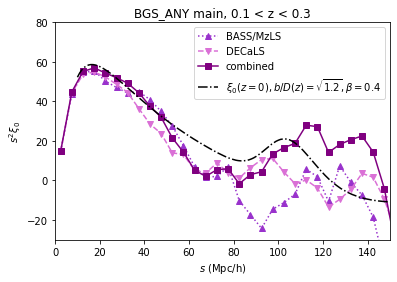

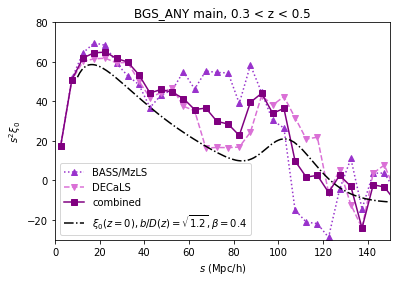

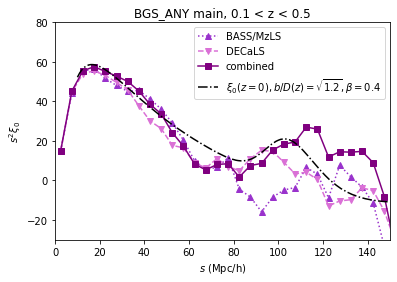

In [12]:
zl = [0.1,0.3,0.5]
for i in range(0,len(zl)):
    if i == len(zl)-1:
        zmin=zl[0]
        zmax=zl[-1]
    else:
        zmin = zl[i]
        zmax = zl[i+1]

    xiln = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024main_testBGS_ANY_N'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xiln[0],xiln[0]**2.*xiln[1],'^:',color='darkorchid',label='BASS/MzLS')
    xils = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024main_testBGS_ANY_S'+str(zmin)+str(zmax)+'5st0.dat').transpose()
 
    plt.plot(xiln[0],xiln[0]**2.*xils[1],'v--',color='orchid',label='DECaLS')
    xil = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024main_testBGS_ANY'+str(zmin)+str(zmax)+'5st0.dat').transpose()

    plt.plot(xil[0],xil[0]**2.*xil[1],'s-',color='purple',label='combined')
    xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    plt.plot(xilin[0],xilin[0]**2.*xilin[1]*1.2,'k-.',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{1.2},\beta=0.4$')

    plt.title('BGS_ANY main, '+str(zmin)+' < z < '+str(zmax))
    plt.xlim(0,150)
    plt.ylim(-30,80)
    plt.xlabel(r'$s$ (Mpc/h)')
    plt.ylabel(r'$s^2\xi_0$')
    plt.legend()
    plt.show()

## wacky things clearly going on for s > 40 mpc/h or so...